In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')
sns.set_color_codes()
%matplotlib inline

In [2]:
data = pd.read_csv('./location_data_hw8.csv')

In [30]:
len(data.t)

100

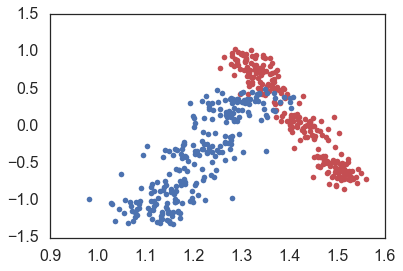

In [3]:
plt.plot(data.red_pos_X, data.red_pos_Y, 'r.')
plt.plot(data.blue_pos_X, data.blue_pos_Y, 'b.')

The true position of each object is modeled by
$$(x,y)=(x_0+vt\cos\theta,\;y_0+vt\sin\theta)$$
The measured positions are subject to Gaussian noise:
$$(x,y)_\text{measured}=N((x,y), \Sigma)$$
where we assume zero covariance:
$$\Sigma = \left(\begin{array}{cc}
\sigma_x & 0\\
0 & \sigma_y
\end{array}\right)$$
We wish to estimate the parameters $\{x_0, y_0, v, \theta, \sigma_x, \sigma_y\}$ for both objects.

In [4]:
import pymc3 as pm

In [5]:
model = pm.Model()

with model:
    # define priors
    v_r = pm.Uniform('v_r', 0.0, 0.1)
    v_b = pm.Uniform('v_b', 0.0, 0.1)
    theta_r = pm.Uniform('theta_r', 0, 360)
    theta_b = pm.Uniform('theta_b', 0, 360)
    x0_r = pm.Uniform('x0_r', 1.2, 1.4)
    y0_r = pm.Uniform('y0_r', 0.8, 1.2)
    x0_b = pm.Uniform('x0_b', 1.0, 1.2)
    y0_b = pm.Uniform('y0_b', -1.4, -1.2)
    sigmax_r = pm.Uniform('sigmax_r', 0.0, 0.1)
    sigmay_r = pm.Uniform('sigmay_r', 0.0, 0.1)
    sigmax_b = pm.Uniform('sigmax_b', 0.0, 0.1)
    sigmay_b = pm.Uniform('sigmay_b', 0.0, 0.1)
    
    # define likelihood
    x_r = pm.Normal('x_r', mu=x0_r+v_r*data.t*np.cos(theta_r/360*2*np.pi), sd=sigmax_r, observed=data.red_pos_X)
    y_r = pm.Normal('y_r', mu=y0_r+v_r*data.t*np.sin(theta_r/360*2*np.pi), sd=sigmay_r, observed=data.red_pos_Y)
    x_b = pm.Normal('x_b', mu=x0_b+v_b*data.t*np.cos(theta_b/360*2*np.pi), sd=sigmax_b, observed=data.blue_pos_X)
    y_b = pm.Normal('y_b', mu=y0_b+v_b*data.t*np.sin(theta_b/360*2*np.pi), sd=sigmay_b, observed=data.blue_pos_Y)

In [6]:
N = 100000

with model:
    step = pm.Metropolis()
    trace = pm.sample(N, step=step, njobs=1)

100%|██████████| 100000/100000 [02:23<00:00, 694.85it/s]


In [7]:
burn_in = trace[int(0.1*N):]
thinned = burn_in[::10]

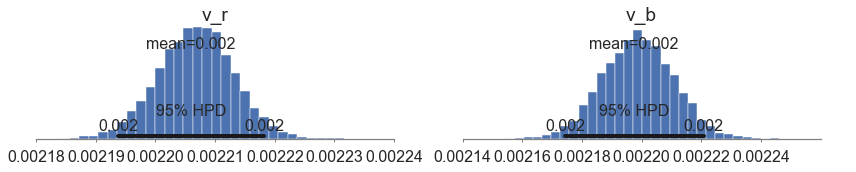

In [8]:
pm.plots.plot_posterior(thinned, varnames=['v_r', 'v_b']);

In [9]:
v_r_pos = thinned['v_r']
v_b_pos = thinned['v_b']
print('Mean: R:', np.mean(v_r_pos), ', B:', np.mean(v_b_pos))
print('5%ile: R:', np.percentile(v_r_pos, 5), ', B:', np.percentile(v_b_pos, 5))
print('95%ile: R:', np.percentile(v_r_pos, 95), ', B:', np.percentile(v_b_pos, 95))

Mean: R: 0.00220597217168 , B: 0.00219721208939
5%ile: R: 0.00219559665621 , B: 0.00217808706693
95%ile: R: 0.00221616884077 , B: 0.00221641072871


The red points have a velocity of $(2.21\pm 0.01)\times 10^{-3}$, and the blue points have velocity of $(2.20\pm 0.02)\times 10^{-3}$

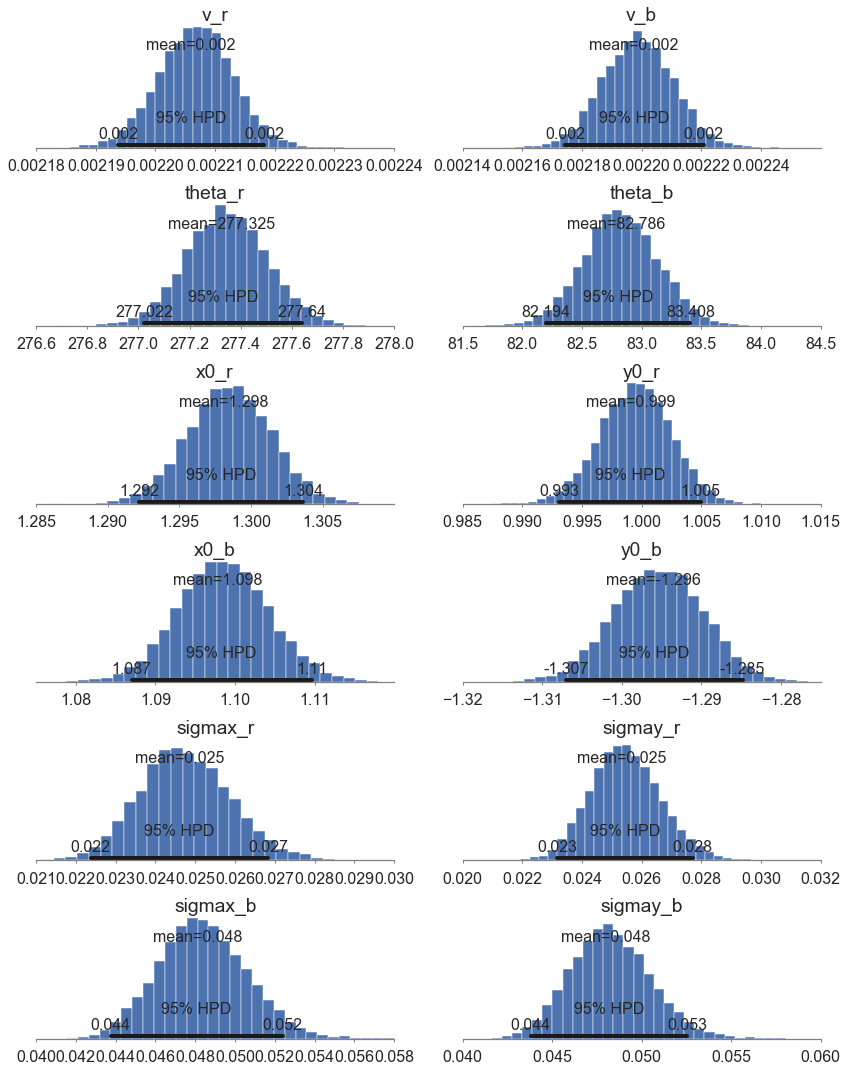

In [10]:
pm.plot_posterior(thinned);

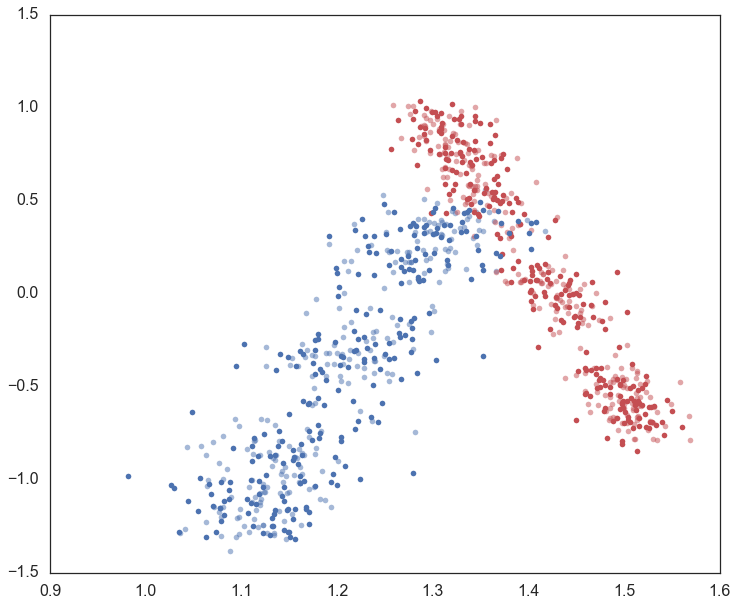

In [11]:
plt.figure(figsize=(12, 10))
realizations = pm.sample_ppc(thinned, model=model, samples=1)
plt.plot(realizations['x_b'], realizations['y_b'], 'b.', alpha=0.5);
plt.plot(realizations['x_r'], realizations['y_r'], 'r.', alpha=0.5);
plt.plot(data.red_pos_X, data.red_pos_Y, 'r.');
plt.plot(data.blue_pos_X, data.blue_pos_Y, 'b.');

We calculate the crossing time of the red and blue objects, i.e. $t_R$ and $t_B$ where

$$y_{0,R}+v_Rt_R\sin\theta_R=0\text{  and  } y_{0,B}+v_Bt_B\sin\theta_B=0,$$

or

$$t_R=\frac{-y_{0,R}}{v_R\sin\theta_R}\text{  and  }t_B=\frac{-y_{0,B}}{v_B\sin\theta_B}$$

In [12]:
rt = -thinned['y0_r']/(thinned['v_r']*np.sin(thinned['theta_r']/360*2*np.pi))
bt = -thinned['y0_b']/(thinned['v_b']*np.sin(thinned['theta_b']/360*2*np.pi))

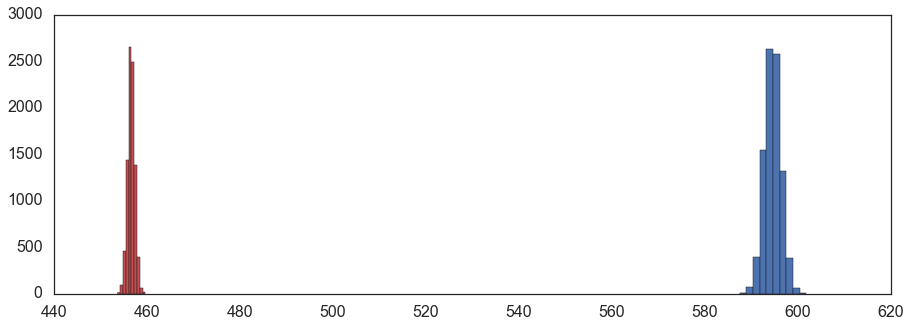

In [13]:
plt.figure(figsize=(15,5))
plt.hist(rt, color='r');
plt.hist(bt, color='b');

In the plot above, times to the left of the red peak are when the blue object is less than 0 and the red is greater than zero. Between the two peaks, the red and blue objects are both below zero. To the right of the blue peak, the red object remains below zero and the blue object crosses above zero.

Therefore, the 90% credible interval on the first time the red object is below zero and the blue object is above zero is effectively the 90% credible interval on the blue crossing time.

In [14]:
print(np.percentile(bt, 5), np.percentile(bt, 95))

591.74674027 597.500988142


# Fix same velocity for red and blue

In [15]:
fixed_v_model = pm.Model()

with fixed_v_model:
    # define priors
    v = pm.Uniform('v', 0.0, 0.1)
    theta_r = pm.Uniform('theta_r', 0, 2*np.pi)
    theta_b = pm.Uniform('theta_b', 0, 2*np.pi)
    x0_r = pm.Uniform('x0_r', 1.2, 1.4)
    y0_r = pm.Uniform('y0_r', 0.8, 1.2)
    x0_b = pm.Uniform('x0_b', 1.0, 1.2)
    y0_b = pm.Uniform('y0_b', -1.4, -1.2)
    sigmax_r = pm.Uniform('sigmax_r', 0.0, 0.1)
    sigmay_r = pm.Uniform('sigmay_r', 0.0, 0.1)
    sigmax_b = pm.Uniform('sigmax_b', 0.0, 0.1)
    sigmay_b = pm.Uniform('sigmay_b', 0.0, 0.1)
    
    # define likelihood
    x_r = pm.Normal('x_r', mu=x0_r+v*data.t*np.cos(theta_r), sd=sigmax_r, observed=data.red_pos_X)
    y_r = pm.Normal('y_r', mu=y0_r+v*data.t*np.sin(theta_r), sd=sigmay_r, observed=data.red_pos_Y)
    x_b = pm.Normal('x_b', mu=x0_b+v*data.t*np.cos(theta_b), sd=sigmax_b, observed=data.blue_pos_X)
    y_b = pm.Normal('y_b', mu=y0_b+v*data.t*np.sin(theta_b), sd=sigmay_b, observed=data.blue_pos_Y)

In [16]:
N = 100000

with fixed_v_model:
    step = pm.Metropolis()
    trace = pm.sample(N, step=step, njobs=1)

100%|██████████| 100000/100000 [02:23<00:00, 695.52it/s]


In [17]:
burn_in = trace[int(0.1*N):]
thinned = burn_in[::10]

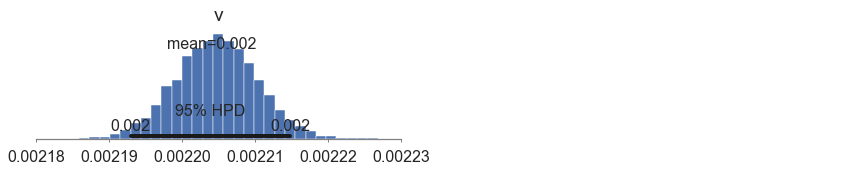

In [18]:
pm.plots.plot_posterior(thinned, varnames=['v']);

In [19]:
v_pos = thinned['v']
print('Mean:', np.mean(v_pos))
print('5%ile:', np.percentile(v_pos, 5))
print('95%ile:', np.percentile(v_pos, 95))

Mean: 0.00220401486683
5%ile: 0.0021949240823
95%ile: 0.00221305253144


The velocity of the objects is $(2.20\pm 0.01)\times 10^{-3}$. This is consistent with our earlier results when we allowed the velocities of each object to vary.

In [20]:
rt = -thinned['y0_r']/(thinned['v']*np.sin(thinned['theta_r']))
bt = -thinned['y0_b']/(thinned['v']*np.sin(thinned['theta_b']))

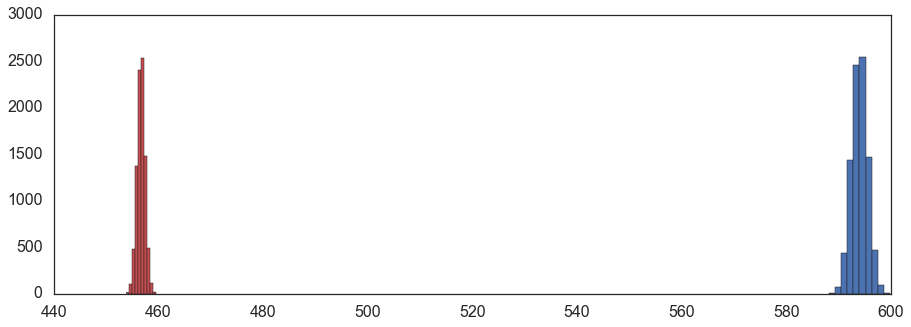

In [21]:
plt.figure(figsize=(15,5))
plt.hist(rt, color='r');
plt.hist(bt, color='b');

In [22]:
print(np.percentile(bt, 5), np.percentile(bt, 95))

591.542938271 596.477975691


# Use only first 100 measurements

In [23]:
data = pd.read_csv('./location_data_hw8.csv')[:100]

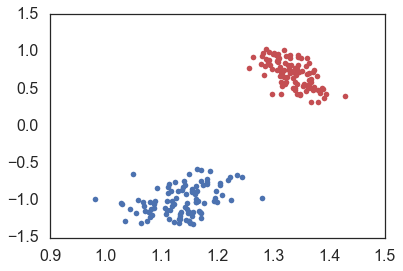

In [24]:
plt.plot(data.red_pos_X, data.red_pos_Y, 'r.')
plt.plot(data.blue_pos_X, data.blue_pos_Y, 'b.');

In [25]:
model = pm.Model()

with model:
    # define priors
    v_r = pm.Uniform('v_r', 0.0, 0.1)
    v_b = pm.Uniform('v_b', 0.0, 0.1)
    theta_r = pm.Uniform('theta_r', 0, 2*np.pi)
    theta_b = pm.Uniform('theta_b', 0, 2*np.pi)
    x0_r = pm.Uniform('x0_r', 1.2, 1.4)
    y0_r = pm.Uniform('y0_r', 0.8, 1.2)
    x0_b = pm.Uniform('x0_b', 1.0, 1.2)
    y0_b = pm.Uniform('y0_b', -1.4, -1.2)
    sigmax_r = pm.Uniform('sigmax_r', 0.0, 0.1)
    sigmay_r = pm.Uniform('sigmay_r', 0.0, 0.1)
    sigmax_b = pm.Uniform('sigmax_b', 0.0, 0.1)
    sigmay_b = pm.Uniform('sigmay_b', 0.0, 0.1)
    
    # define likelihood
    x_r = pm.Normal('x_r', mu=x0_r+v_r*data.t*np.cos(theta_r), sd=sigmax_r, observed=data.red_pos_X)
    y_r = pm.Normal('y_r', mu=y0_r+v_r*data.t*np.sin(theta_r), sd=sigmay_r, observed=data.red_pos_Y)
    x_b = pm.Normal('x_b', mu=x0_b+v_b*data.t*np.cos(theta_b), sd=sigmax_b, observed=data.blue_pos_X)
    y_b = pm.Normal('y_b', mu=y0_b+v_b*data.t*np.sin(theta_b), sd=sigmay_b, observed=data.blue_pos_Y)

In [26]:
N = 100000

with model:
    step = pm.Metropolis()
    trace = pm.sample(N, step=step, njobs=1)

100%|██████████| 100000/100000 [02:21<00:00, 709.10it/s]


In [27]:
burn_in = trace[int(0.1*N):]
thinned = burn_in[::10]

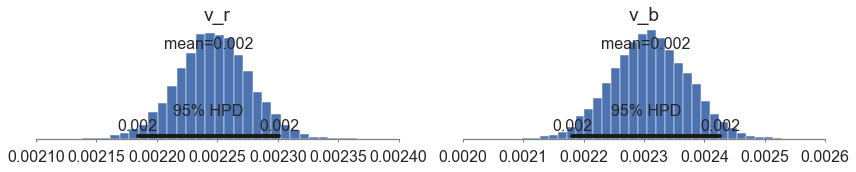

In [28]:
pm.plots.plot_posterior(thinned, varnames=['v_r', 'v_b']);

In [29]:
v_r_pos = thinned['v_r']
v_b_pos = thinned['v_b']
print('Mean: R:', np.mean(v_r_pos), ', B:', np.mean(v_b_pos))
print('5%ile: R:', np.percentile(v_r_pos, 5), ', B:', np.percentile(v_b_pos, 5))
print('95%ile: R:', np.percentile(v_r_pos, 95), ', B:', np.percentile(v_b_pos, 95))

Mean: R: 0.00224319154956 , B: 0.00230247531193
5%ile: R: 0.00219449586145 , B: 0.00219840581062
95%ile: R: 0.00229260464495 , B: 0.00240552934094


The red points have a velocity of $(2.21\pm 0.05)\times 10^{-3}$, and the blue points have velocity of $(2.2\pm 0.1)\times 10^{-3}$. As expected, we have similar final results, but with larger uncertainties.

In [34]:
rt = -thinned['y0_r']/(thinned['v_r']*np.sin(thinned['theta_r']))
bt = -thinned['y0_b']/(thinned['v_b']*np.sin(thinned['theta_b']))

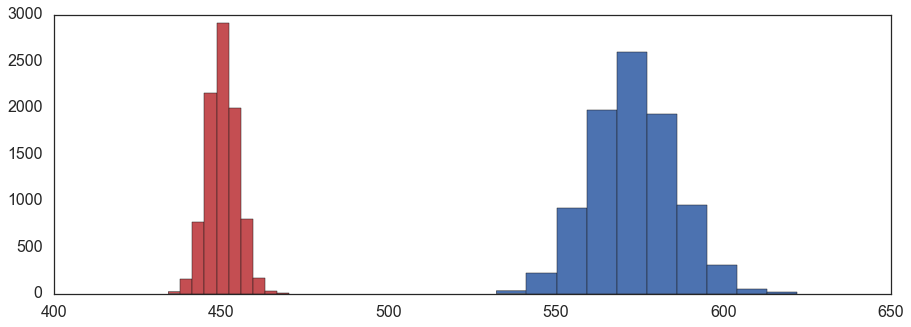

In [35]:
plt.figure(figsize=(15,5))
plt.hist(rt, color='r');
plt.hist(bt, color='b');

In [36]:
print(np.percentile(rt, 5), np.percentile(bt, 95))

443.262927162 593.887044857


# First 100 measurements and fix same velocity

In [37]:
fixed_v_model = pm.Model()

with fixed_v_model:
    # define priors
    v = pm.Uniform('v', 0.0, 0.1)
    theta_r = pm.Uniform('theta_r', 0, 2*np.pi)
    theta_b = pm.Uniform('theta_b', 0, 2*np.pi)
    x0_r = pm.Uniform('x0_r', 1.2, 1.4)
    y0_r = pm.Uniform('y0_r', 0.8, 1.2)
    x0_b = pm.Uniform('x0_b', 1.0, 1.2)
    y0_b = pm.Uniform('y0_b', -1.4, -1.2)
    sigmax_r = pm.Uniform('sigmax_r', 0.0, 0.1)
    sigmay_r = pm.Uniform('sigmay_r', 0.0, 0.1)
    sigmax_b = pm.Uniform('sigmax_b', 0.0, 0.1)
    sigmay_b = pm.Uniform('sigmay_b', 0.0, 0.1)
    
    # define likelihood
    x_r = pm.Normal('x_r', mu=x0_r+v*data.t*np.cos(theta_r), sd=sigmax_r, observed=data.red_pos_X)
    y_r = pm.Normal('y_r', mu=y0_r+v*data.t*np.sin(theta_r), sd=sigmay_r, observed=data.red_pos_Y)
    x_b = pm.Normal('x_b', mu=x0_b+v*data.t*np.cos(theta_b), sd=sigmax_b, observed=data.blue_pos_X)
    y_b = pm.Normal('y_b', mu=y0_b+v*data.t*np.sin(theta_b), sd=sigmay_b, observed=data.blue_pos_Y)

In [38]:
N = 100000

with fixed_v_model:
    step = pm.Metropolis()
    trace = pm.sample(N, step=step, njobs=1)

100%|██████████| 100000/100000 [02:12<00:00, 756.29it/s]


In [39]:
burn_in = trace[int(0.1*N):]
thinned = burn_in[::10]

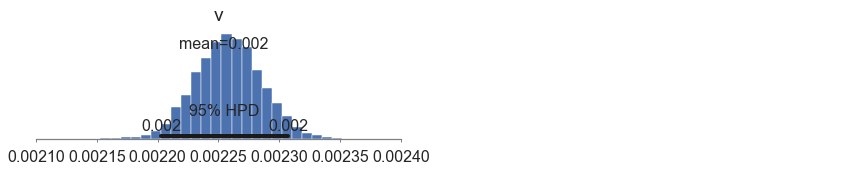

In [40]:
pm.plots.plot_posterior(thinned, varnames=['v']);

In [41]:
v_pos = thinned['v']
print('Mean:', np.mean(v_pos))
print('5%ile:', np.percentile(v_pos, 5))
print('95%ile:', np.percentile(v_pos, 95))

Mean: 0.00225421026567
5%ile: 0.00221065394718
95%ile: 0.00229878254843


The velocity is $(2.25 \pm 0.05)\times 10^{-3}$. This is once again similar to the result found using all of the data, but with higher uncertainty.

In [42]:
rt = -thinned['y0_r']/(thinned['v']*np.sin(thinned['theta_r']))
bt = -thinned['y0_b']/(thinned['v']*np.sin(thinned['theta_b']))

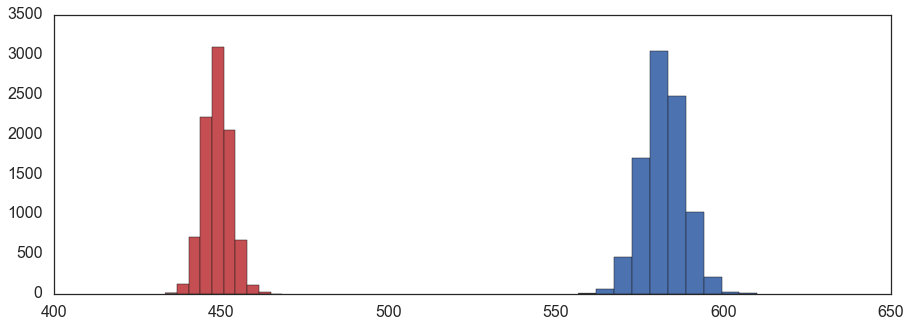

In [43]:
plt.figure(figsize=(15,5))
plt.hist(rt, color='r');
plt.hist(bt, color='b');

In [44]:
print(np.percentile(rt, 5), np.percentile(bt, 95))

442.444637388 592.260279548
